In [1]:
import numpy as np    
import pandas as pd  

import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import gridspec


from datetime import datetime
import datetime as dt

In [2]:
raw_data = pd.read_csv('PopTrendsBData3Aggs.csv')
df = pd.DataFrame(raw_data)
df.head().style

,UserID,CountryID,Gender,BirthYear,DateReg,TimeReg,Date1Dep,Date1Bet,Date1Spo,StakeF,StakeL,StakeA,WinF,WinL,WinA,BetsF,BetsL,BetsA,DaysF,DaysL,DaysA
0,1324354,276,1,1963.000000,2005-02-01,00:01,2005-02-24,2005-02-24,2005-02-24,15750.380000,2146.470000,17896.850000,15010.900000,1809.950000,16820.850000,727,71,798,231,33,233
1,1324355,300,1,1983.000000,2005-02-01,00:05,2005-02-01,2005-02-01,2005-02-01,639.299800,24.700000,663.999800,569.370000,11.200000,580.570000,286,21,307,99,7,101
2,1324356,276,1,1977.000000,2005-02-01,00:05,2005-02-01,2005-02-02,2005-02-02,898.810000,701.820000,1600.630000,336.360000,649.270000,985.630000,116,126,242,48,27,54
3,1324358,752,1,1981.000000,2005-02-01,00:08,2005-02-01,2005-02-01,2005-02-01,247.697000,88.592700,336.289700,153.875500,55.981900,209.857400,7,4,11,5,1,5
4,1324360,792,1,1978.000000,2005-02-01,00:09,2005-02-02,2005-02-02,2005-02-02,685.942400,6.664100,692.606500,623.898400,3.052800,626.951200,386,8,394,58,4,60


In [3]:
df.shape

(46339, 21)

In [4]:
# examine the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46339 entries, 0 to 46338
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   UserID     46339 non-null  int64  
 1   CountryID  46339 non-null  int64  
 2   Gender     46339 non-null  int64  
 3   BirthYear  46337 non-null  float64
 4   DateReg    46339 non-null  object 
 5   TimeReg    46339 non-null  object 
 6   Date1Dep   46339 non-null  object 
 7   Date1Bet   46339 non-null  object 
 8   Date1Spo   46339 non-null  object 
 9   StakeF     46339 non-null  float64
 10  StakeL     46339 non-null  float64
 11  StakeA     46339 non-null  float64
 12  WinF       46339 non-null  float64
 13  WinL       46339 non-null  float64
 14  WinA       46339 non-null  float64
 15  BetsF      46339 non-null  int64  
 16  BetsL      46339 non-null  int64  
 17  BetsA      46339 non-null  int64  
 18  DaysF      46339 non-null  int64  
 19  DaysL      46339 non-null  int64  
 20  DaysA 

In [5]:
# All information seems adequate, execpt for 2 null values in column birthYear
# Count the number of null values in the dataset to verify
print('Number of null values:',df.isnull().values.sum())

Number of null values: 2


In [6]:
# remove rows with null values
df.dropna(subset=['BirthYear'], inplace=True)

# drop duplicate rows
df.drop_duplicates(inplace=True)

# drop irrelevant columns (features that are not helful to the purpose of the project)
df = df.drop(['CountryID', 'Gender', 'BirthYear', 'TimeReg', 'Date1Spo'], axis=1)

In [7]:
df.describe().round()

,UserID,StakeF,StakeL,StakeA,WinF,WinL,WinA,BetsF,BetsL,BetsA,DaysF,DaysL,DaysA
count,46337.0,46337.0,46337.0,46337.0,46337.0,46337.0,46337.0,46337.0,46337.0,46337.0,46337.0,46337.0,46337.0
mean,1365007.0,1193.0,1578.0,2771.0,1039.0,1473.0,2512.0,200.0,108.0,308.0,41.0,15.0,46.0
std,23226.0,5125.0,13280.0,15988.0,4795.0,12661.0,15088.0,577.0,532.0,904.0,58.0,39.0,65.0
min,1324354.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
25%,1345068.0,68.0,0.0,99.0,27.0,0.0,49.0,14.0,0.0,20.0,6.0,0.0,8.0
50%,1365091.0,217.0,20.0,305.0,152.0,10.0,228.0,52.0,5.0,76.0,20.0,3.0,23.0
75%,1385061.0,699.0,176.0,1040.0,574.0,145.0,884.0,169.0,40.0,242.0,50.0,12.0,57.0
max,1405190.0,380094.0,746243.0,843124.0,420949.0,723319.0,812114.0,23986.0,22076.0,36832.0,543.0,549.0,556.0


In [8]:
# Renaming columns for better comprehension
df.columns = [
    'user_ID', 'date_registered', 'date_of_1st_deposit', 'date_of_1st_bet', 'stake_fixed', 
    'stake_live', 'stake_total', 'win_fixed', 'win_live', 'win_total', 
    'bets_fixed', 'bets_live', 'bets_total', 'days_fixed',
    'days_live', 'days_total'
]

# There are 3 columns that store data of dates 
# convert data in these columns (DateRegistered, Date1Deposit, Date1Bet) from string to datetime
df['date_of_1st_bet'] = pd.to_datetime(df['date_of_1st_bet'])
df['date_registered'] = pd.to_datetime(df['date_registered'])
df['date_of_1st_deposit'] = pd.to_datetime(df['date_of_1st_deposit'])

# filter datapoints that represent inactive players
df = df[df['bets_total'] > 0]

## Descriptive analysis

In [9]:
# create 4 new columns to examine the sport betting behaviours of players
df['profit_total'] = df['win_total'] - df['stake_total'] #profit_total is what we are going to try to predict in the next phase of the project
df['winning'] = df['profit_total'].apply(lambda x: 1 if x >= 0 else 0)

<Axes: >

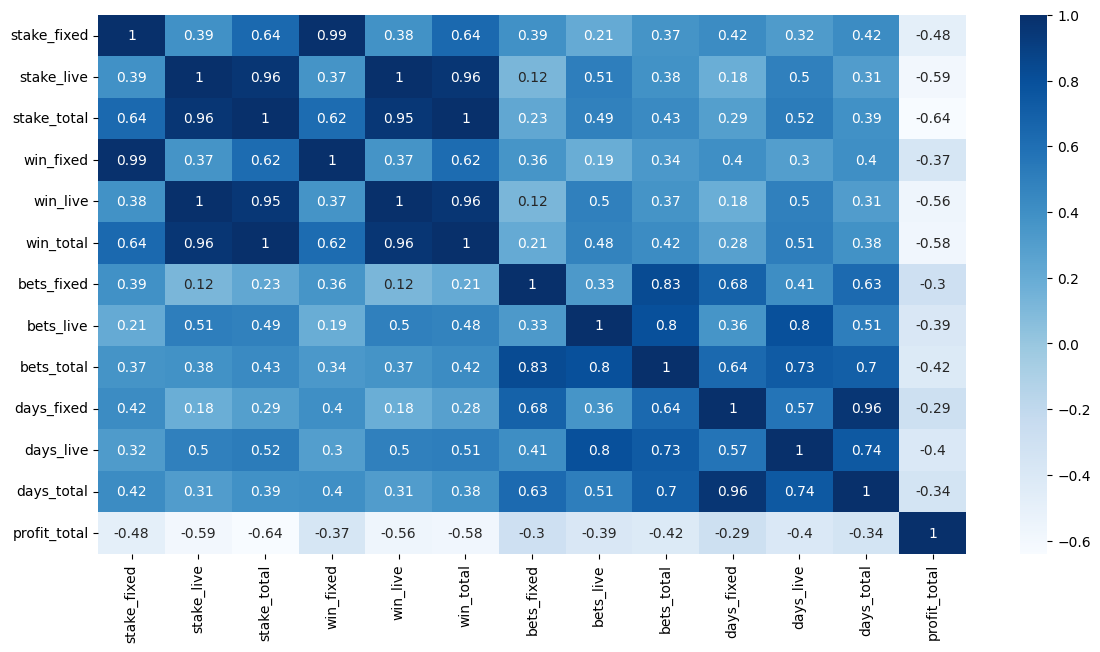

In [10]:
# First, we draw a correlation heatmap of all numerical features
df1 = df.drop(['user_ID', 'date_registered', 'date_of_1st_deposit', 'date_of_1st_bet', 'winning'], axis = 1)
correlation = df1.corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True, cmap="Blues")

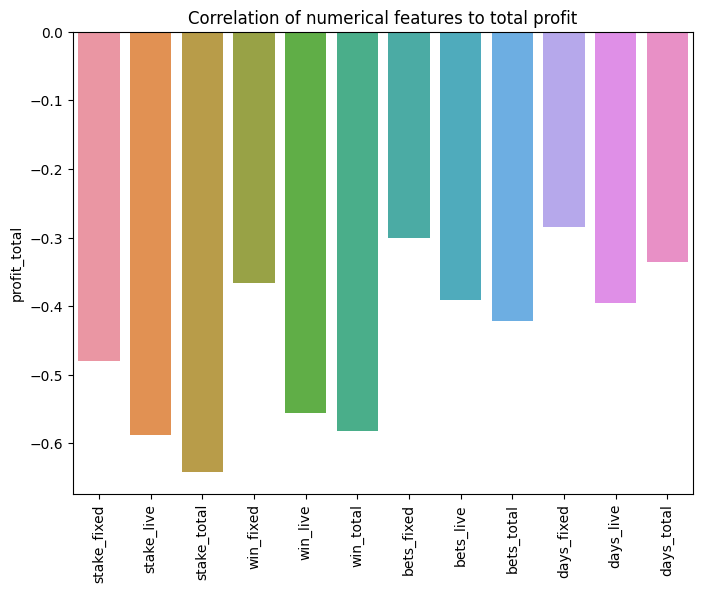

In [11]:
# We take a closer look into the correlation betweent total profit and other numerical variables
corr = df1.corr().profit_total
plt.figure(figsize = (8,6))
sns.barplot(x = corr[:-1].index, y = corr[:-1])
plt.title('Correlation of numerical features to total profit')
plt.xticks(rotation=90)
plt.show()

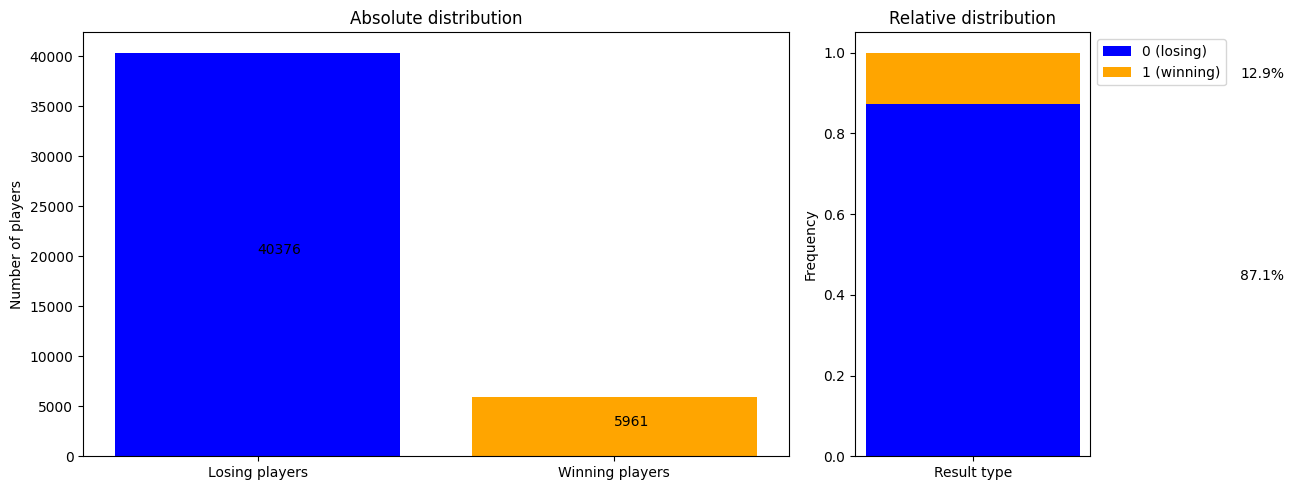

In [12]:
#Exploratory data analytics and visualizations

# plot number of losing/winning players
keys, counts = np.unique(df.winning, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(13, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5,0.5])

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['Losing players', 'Winning players'], counts, color = ['blue', 'orange']) 
ax0 = plt.title('Absolute distribution') 
ax0 = plt.ylabel('Number of players')
ax0 = plt.text(keys[0], counts[0]/2, counts[0])
ax0 = plt.text(keys[1], counts[1]/2, counts[1])

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Result type'], [counts_norm[0]], label='0 (losing)', color = 'blue')
ax1 = plt.bar(['Result type'], [counts_norm[1]], bottom=counts_norm[0], label='1 (winning)', color = 'orange')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Relative distribution')
ax1 = plt.ylabel('Frequency')
ax1 = plt.text(['Response type'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Response type'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))


plt.tight_layout()
plt.show()

In [48]:
# live sport bets and fixed sport bets statistics

# check if live or fixed sport bet is more common among customers
live_bets_all = df['bets_live'].sum()
fixed_bets_all = df['bets_fixed'].sum()

# total money spent on live sport bet and fixed sport bet
stake_live_all = round(df['stake_live'].sum(),2)
stake_fixed_all = round(df['stake_fixed'].sum(), 2)

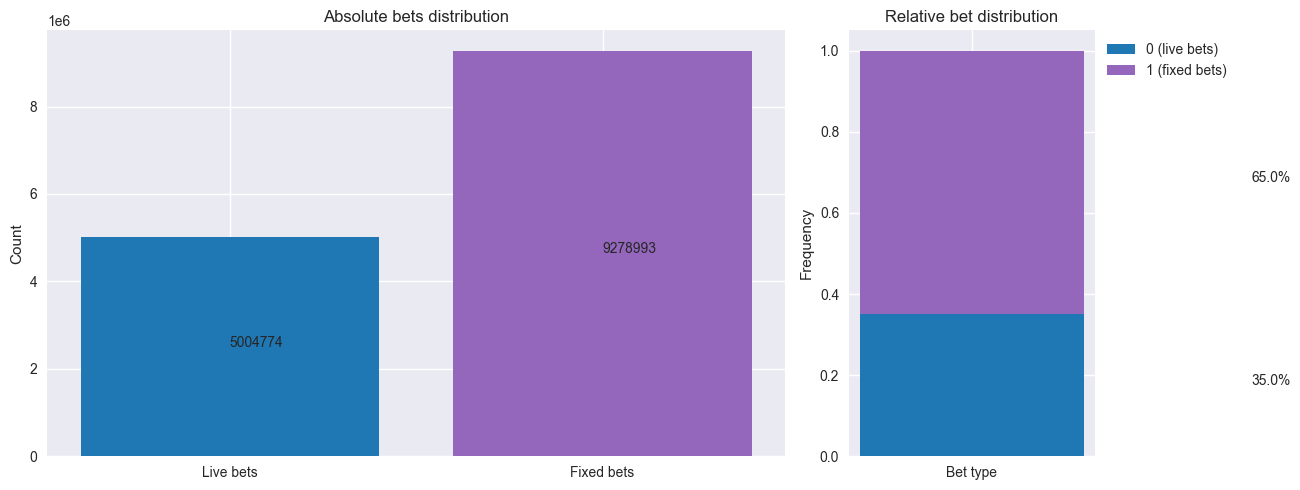

In [49]:
# plotting bets statistics of all players combined
keys = np.array([0,1])
counts = np.array([live_bets_all, fixed_bets_all])

total = live_bets_all + fixed_bets_all
counts_norm = np.array([live_bets_all/total, fixed_bets_all/total])

fig = plt.figure(figsize=(13, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5,0.5])

# color combination
colors = ['#1f77b4', '#9467bd']

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['Live bets', 'Fixed bets'], counts, color = colors) 
ax0 = plt.title('Absolute bets distribution') 
ax0 = plt.ylabel('Count')
ax0 = plt.text(keys[0], counts[0]/2, counts[0])
ax0 = plt.text(keys[1], counts[1]/2, counts[1])

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Bet type'], [counts_norm[0]], label='0 (live bets)', color = colors[0])
ax1 = plt.bar(['Bet type'], [counts_norm[1]], bottom=counts_norm[0], label='1 (fixed bets)', color = colors[1])
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Relative bet distribution')
ax1 = plt.ylabel('Frequency')
ax1 = plt.text(['Response type'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Response type'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))


plt.tight_layout()
plt.show()


In [50]:
# fixed bets are more preferred among players
# 65% of all bets placed by players are fixed bets 

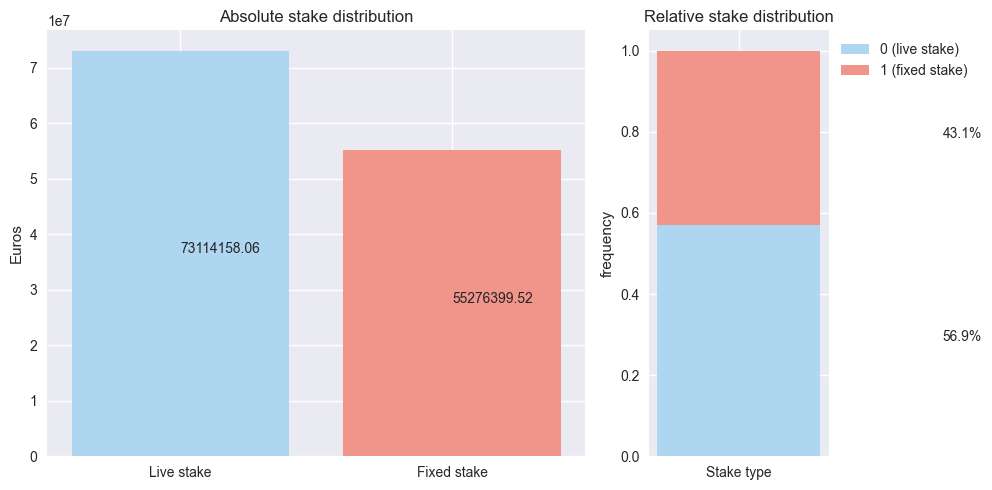

In [51]:
# plotting stake statistics of all players combined
keys = np.array([0,1])
counts = np.array([stake_live_all, stake_fixed_all])

total = stake_live_all + stake_fixed_all
counts_norm = np.array([stake_live_all/total, stake_fixed_all/total])

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5,0.5])

# colors
colors = ['#AED6F1', '#F1948A']

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['Live stake', 'Fixed stake'], counts, color = colors) 
ax0 = plt.title('Absolute stake distribution') 
ax0 = plt.ylabel('Euros')
ax0 = plt.text(keys[0], counts[0]/2, counts[0])
ax0 = plt.text(keys[1], counts[1]/2, counts[1])

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Stake type'], [counts_norm[0]], label='0 (live stake)', color = colors[0])
ax1 = plt.bar(['Stake type'], [counts_norm[1]], bottom=counts_norm[0], label='1 (fixed stake)', color = colors[1])
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Relative stake distribution')
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['stake type'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['stake type'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))


plt.tight_layout()
plt.show()

In [52]:
#  even though live bets only acount for 35% of all bets, live stake accounts for up to 56.9% of the total stake
#  players, in total, made more fixed bets, but spent more money on live bets. 

In [53]:
# analyse winning players
winning_players = df[df['profit_total'] >= 0]

winner_live_bets = winning_players['bets_live'].sum()
winner_fixed_bets = winning_players['bets_fixed'].sum()

winner_stake_live = winning_players['stake_live'].sum()
winner_stake_fixed = winning_players['stake_fixed'].sum()

In [54]:
# analyse losing players
losing_players = df[df['profit_total'] < 0]

loser_live_bets = losing_players['bets_live'].sum()
loser_fixed_bets = losing_players['bets_fixed'].sum()

loser_stake_live = losing_players['stake_live'].sum()
loser_stake_fixed = losing_players['stake_fixed'].sum()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_41636\2440087036.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


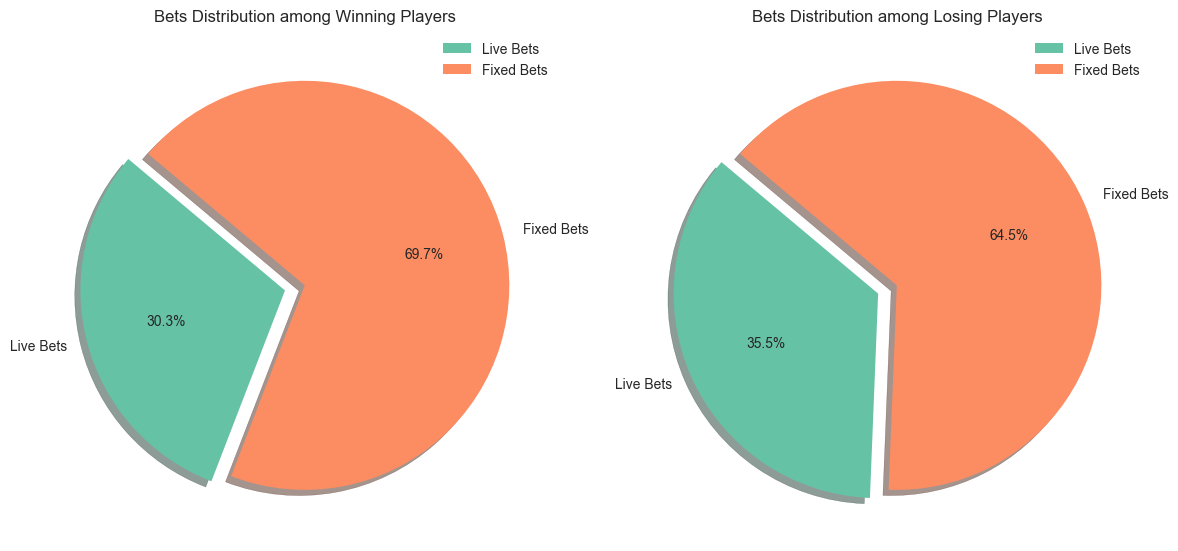

In [55]:
# Set data
set1_data = {
    "Metric": ["Live Bets", "Fixed Bets"],
    "Value": [winner_live_bets, winner_fixed_bets]
}

set2_data = {
    "Metric": ["Live Bets", "Fixed Bets"],
    "Value": [loser_live_bets, loser_fixed_bets]
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Define a color palette
colors = ['#66c2a5', '#fc8d62']

# Pie Chart for Set1
axes[0].pie(set1_data["Value"], labels=set1_data["Metric"], autopct='%1.1f%%', startangle=140, colors=colors,
            shadow=True, explode=(0.1, 0))
axes[0].set_title('Bets Distribution among Winning Players')
axes[0].legend(loc='best')

# Pie Chart for Set2
axes[1].pie(set2_data["Value"], labels=set2_data["Metric"], autopct='%1.1f%%', startangle=140, colors=colors,
            shadow=True, explode=(0.1, 0))
axes[1].set_title('Bets Distribution among Losing Players')
axes[1].legend(loc='best')


plt.tight_layout()
plt.style.use('seaborn')
plt.show()


In [56]:
# relatively similar distribution, doesn't say much

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_41636\4264771585.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


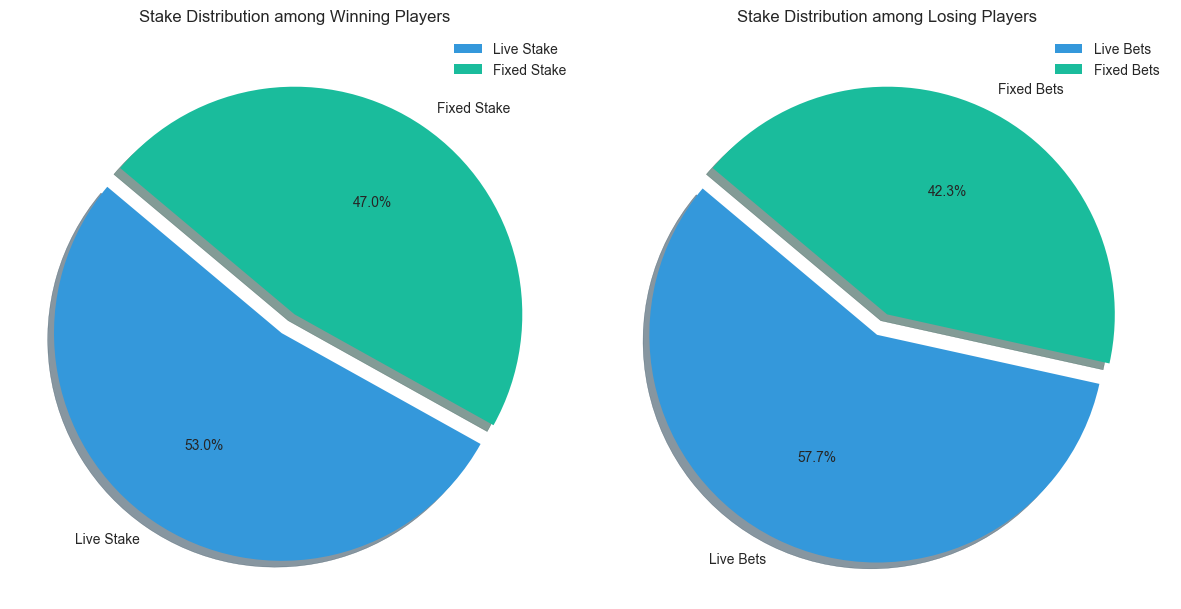

In [57]:
# Set data
set1_data = {
    "Metric": ["Live Stake", "Fixed Stake"],
    "Value": [winner_stake_live, winner_stake_fixed]
}

set2_data = {
    "Metric": ["Live Bets", "Fixed Bets"],
    "Value": [loser_stake_live, loser_stake_fixed]
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Define a color palette
colors = ['#3498db', '#1abc9c']

# Pie Chart for Set1
axes[0].pie(set1_data["Value"], labels=set1_data["Metric"], autopct='%1.1f%%', startangle=140, colors=colors,
            shadow=True, explode=(0.1, 0))
axes[0].set_title('Stake Distribution among Winning Players')
axes[0].legend(loc='best')

# Pie Chart for Set2
axes[1].pie(set2_data["Value"], labels=set2_data["Metric"], autopct='%1.1f%%', startangle=140, colors=colors,
            shadow=True, explode=(0.1, 0))
axes[1].set_title('Stake Distribution among Losing Players')
axes[1].legend(loc='best')

# Adjust spacing between subplots
plt.tight_layout()

# Set a style (optional, you can remove this line if you prefer the default style)
plt.style.use('seaborn')

# Show the plots
plt.show()


In [58]:
# relatively similar, doesn't say much

In [59]:
# create a new columns for time_series analysis
df['registration_to_1st_deposit'] = df['date_of_1st_deposit'] - df['date_registered']
df['registration_to_1st_deposit'] = df['registration_to_1st_deposit'].dt.days

df['registration_to_1st_bet'] = df['date_of_1st_bet'] - df['date_registered']
df['registration_to_1st_bet'] = df['registration_to_1st_bet'].dt.days

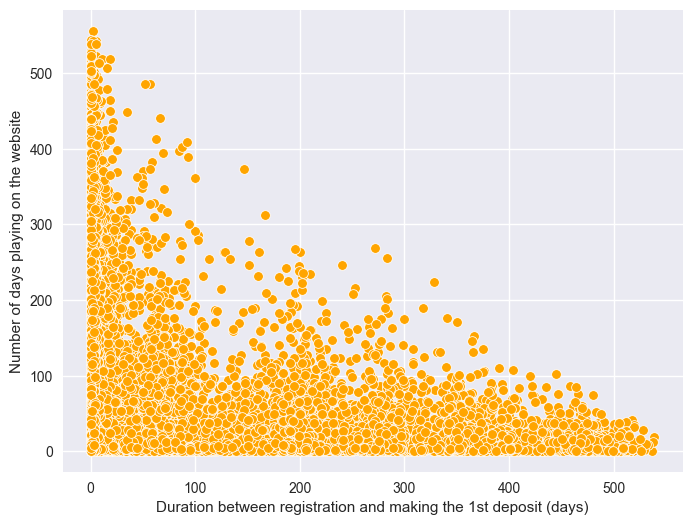

In [60]:
# Time series addwdad
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='registration_to_1st_deposit', y='days_total', color = 'orange')
plt.xlabel('Duration between registration and making the 1st deposit (days)')
plt.ylabel('Number of days playing on the website')
plt.grid(True)
plt.show()

In [61]:
# Most of the customers played for less than 100 days.
# The majority of the customers who played for more than 
# 100 days made their 1st deposits very early after their registration. 
# We take a deeper look at the players who played for more than 100 days. 

In [62]:
def sort_days_range(total_days):
    if total_days >= 100 and total_days <= 200: 
        return 1
    elif total_days >= 201 and total_days <= 300:
        return 2
    elif total_days >= 301 and total_days <= 400:
        return 3
    elif total_days >= 401: 
        return 4
    else:
        return 0

def sort_first_deposit(total_days):
    if total_days >= 0 and total_days <= 6: 
        return 1
    elif total_days >= 7 and total_days <= 13:
        return 2
    elif total_days >= 14 and total_days <= 20:
        return 3
    elif total_days >= 21: 
        return 4

df['days_total_range'] = df['days_total'].apply(sort_days_range)
df['first_deposit_range'] = df['registration_to_1st_deposit'].apply(sort_first_deposit)
gr1 = len(df[df['days_total_range'] == 1])
gr2 = len(df[df['days_total_range'] == 2])
gr3 = len(df[df['days_total_range'] == 3])
gr4 = len(df[df['days_total_range'] == 4])


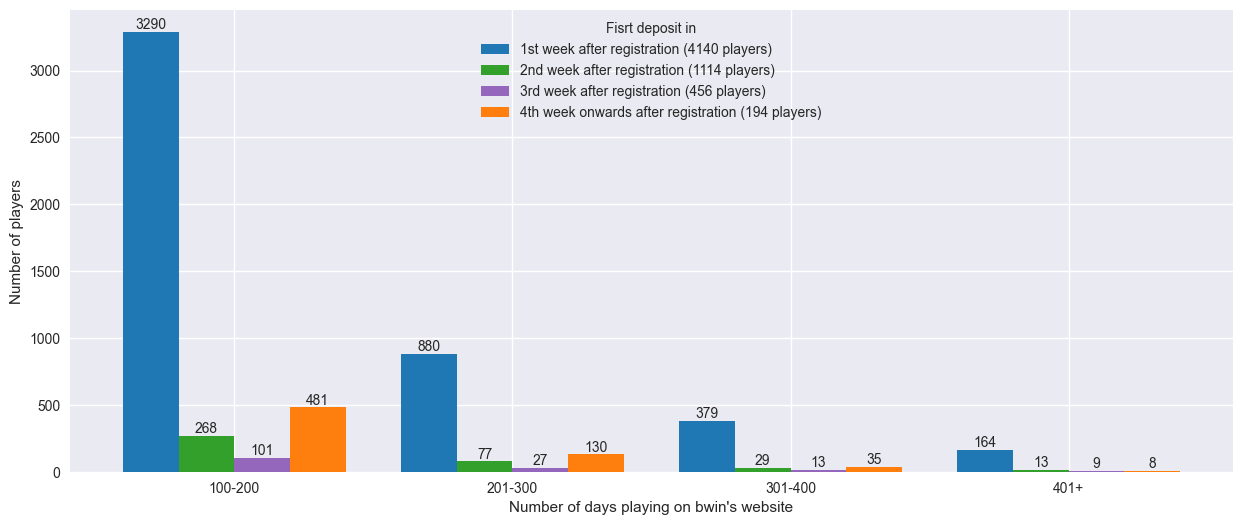

In [63]:
# Define the categories and initialize counts
df1 = df[df['days_total_range'] != 0]

# Group and count the data
counts = df1.groupby(['days_total_range', 'first_deposit_range']).size().unstack(fill_value=0)

# Create the barplot
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.2
index = range(1, 5)

colors = ['#1f77b4', '#33a02c', '#9467bd', '#ff7f0e']

for i in range(4):
    x_values = [x + i * bar_width for x in index]
    bar = plt.bar(x_values, counts[i + 1], bar_width)
    
    # Annotate the bars with their y-values
    for x, y in zip(x_values, counts[i + 1]):
        plt.text(x, y, str(y), ha='center', va='bottom')

plt.bar([x + 0 * bar_width for x in index], counts[0 + 1], bar_width, label=f'1st week after registration ({(gr1)} players)', color=colors[0])
plt.bar([x + 1 * bar_width for x in index], counts[1 + 1], bar_width, label=f'2nd week after registration ({(gr2)} players)', color=colors[1])
plt.bar([x + 2 * bar_width for x in index], counts[2 + 1], bar_width, label=f'3rd week after registration ({(gr3)} players)', color=colors[2])
plt.bar([x + 3 * bar_width for x in index], counts[3 + 1], bar_width, label=f'4th week onwards after registration ({(gr4)} players)', color=colors[3])


plt.xlabel("Number of days playing on bwin's website")
plt.ylabel("Number of players")
plt.xticks([x + 1.5 * bar_width for x in index], ['100-200', '201-300', '301-400', '401+'])  # Replace labels with desired values
plt.legend(loc='upper center', title = 'Fisrt deposit in')


plt.show()



In [64]:
# A very high portion of players who played for more than 100 days made their first deposit in the 1st week after registration
# In all 4 groups, the portions of players making their first deposit in the 1st week after registration dominate

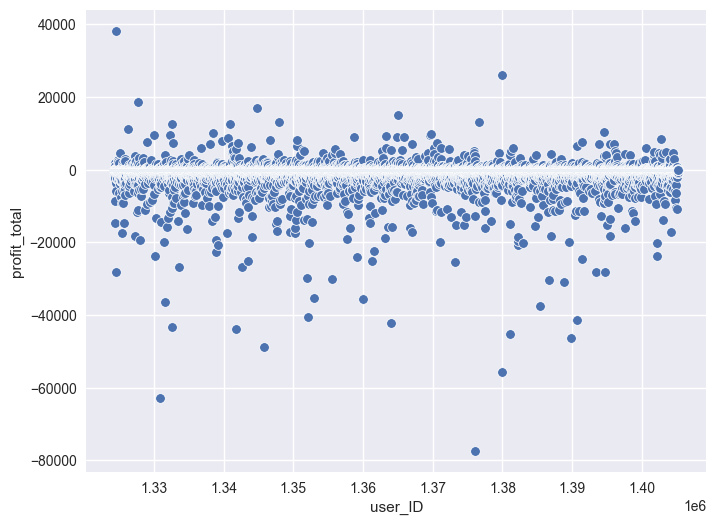

In [65]:
# Next, week take a look at the anomalies in the dataset, particularly big-time losing players. 
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='user_ID', y='profit_total')
plt.grid(True)
plt.show()

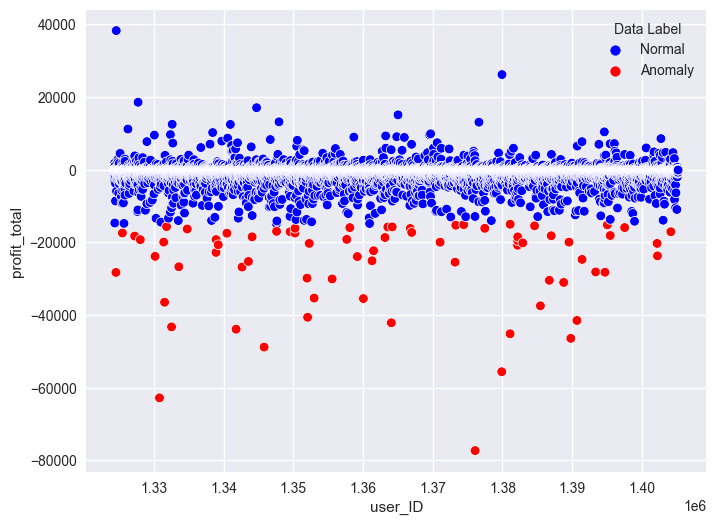

In [66]:
# we use Z-score method to filter out anomalies big-time losing players  
from scipy import stats
z_scores = stats.zscore(df['profit_total'])
# in this case, we take 10 as the threshold
filtered_df = df[abs(z_scores) > 10]
filtered_df = filtered_df[filtered_df['profit_total'] <= 0]

df['Label'] = 'Normal'  # All points initially labeled as 'Normal'
df.loc[df.index.isin(filtered_df.index), 'Label'] = 'Anomaly'

# Define the colors for 'Anomaly' and 'Normal'
palette = {'Anomaly': 'red', 'Normal': 'blue'}

# Create the scatter plot with hue and palette
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='user_ID', y='profit_total', hue='Label', palette=palette)
plt.grid(True)

# Create a legend
plt.legend(title='Data Label', loc='upper right')

plt.show()


In [67]:
# analyse big-time losing players
big_losing_bets_live = filtered_df['bets_live'].sum()
big_losing_bets_fixed = filtered_df['bets_fixed'].sum()

big_losing_stake_live = filtered_df['stake_live'].sum()
big_losing_stake_fixed = filtered_df['stake_fixed'].sum()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_41636\1657382203.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


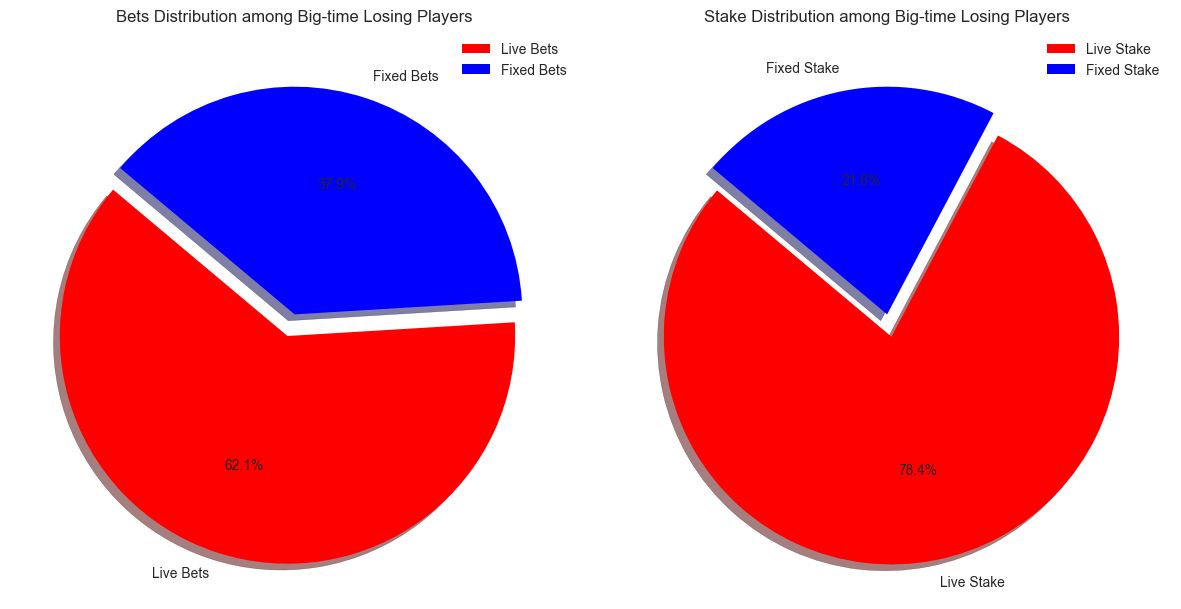

In [68]:
# Set data
set1_data = {
    "Metric": ["Live Bets", "Fixed Bets"],
    "Value": [big_losing_bets_live, big_losing_bets_fixed]
}

set2_data = {
    "Metric": ["Live Stake", "Fixed Stake"],
    "Value": [big_losing_stake_live, big_losing_stake_fixed]
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Define a color palette
colors = ['red', 'blue']

# Pie Chart for Set1
axes[0].pie(set1_data["Value"], labels=set1_data["Metric"], autopct='%1.1f%%', startangle=140, colors=colors,
            shadow=True, explode=(0.1, 0))
axes[0].set_title('Bets Distribution among Big-time Losing Players')
axes[0].legend(loc='best')

# Pie Chart for Set2
axes[1].pie(set2_data["Value"], labels=set2_data["Metric"], autopct='%1.1f%%', startangle=140, colors=colors,
            shadow=True, explode=(0.1, 0))
axes[1].set_title('Stake Distribution among Big-time Losing Players')
axes[1].legend(loc='best')


plt.tight_layout()
plt.style.use('seaborn')
plt.show()


In [81]:
# The proportion of live bets is double to that of winning players (62.1% compared to 30.3%)
# The proportion of live stake is 78.4% compared to 53% of winning players
# => very different betting patterns compared to winning players (placed more live bets and spent significantly 
# more money on live bets)

## Modeling

In [83]:
# Based on the correlation matrix, these features seem to have high correlations to the total profit. 
# days_total, bets_total, stake_total
# We examine them further

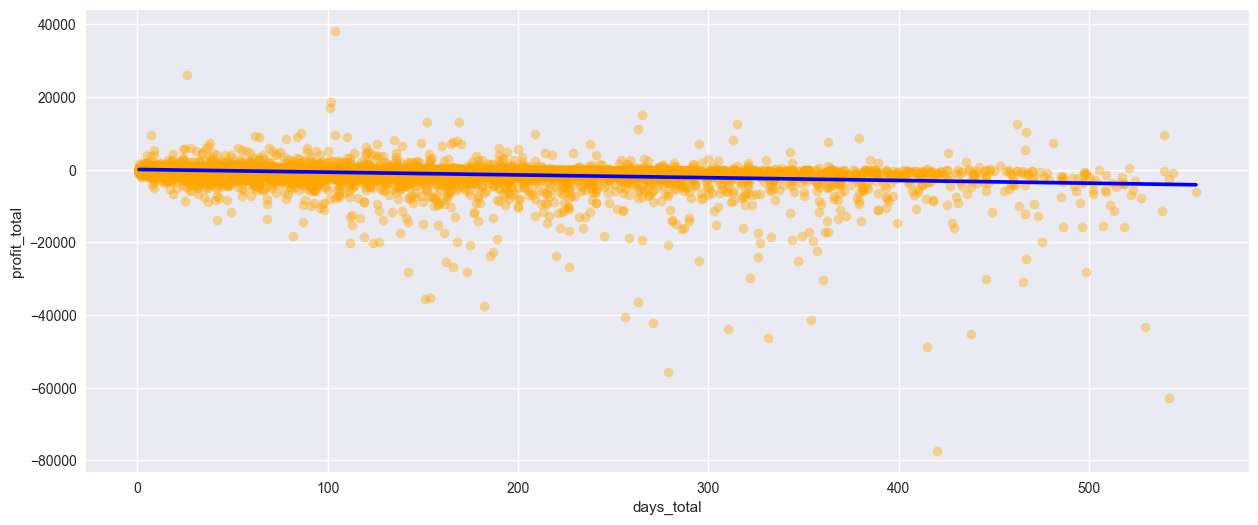

In [70]:
# Visualizing relationships between days_total and profit_total
plt.figure(figsize=(15, 6))
sns.regplot(data=df, x='days_total', y='profit_total', scatter_kws={"color": "orange",  "alpha":0.4}, line_kws={"color": "blue", "alpha":1})
plt.grid(True)
plt.show()

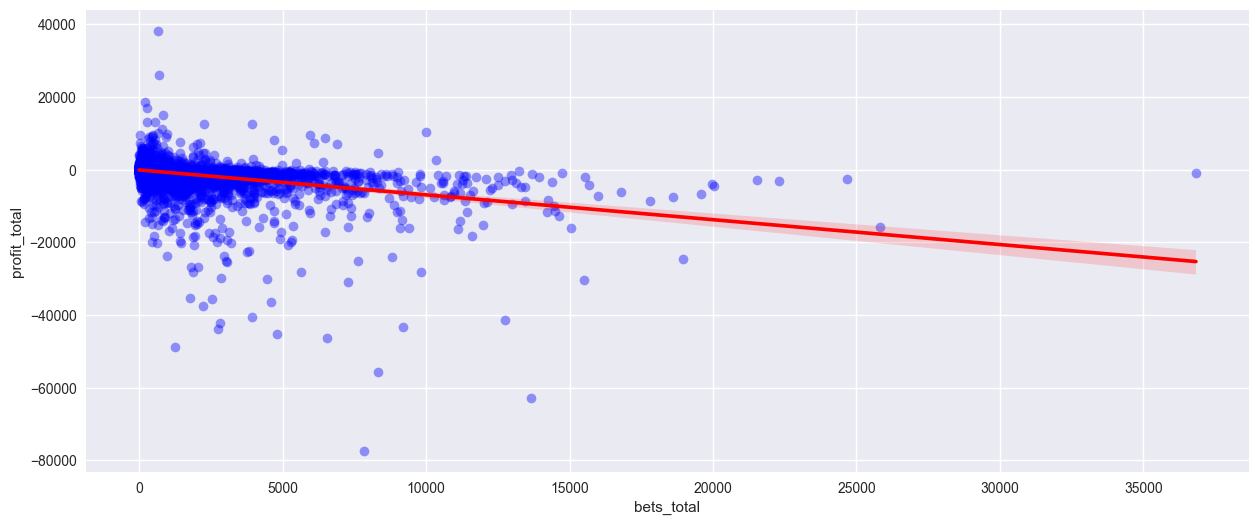

In [85]:
# Visualizing relationships between bets_total and profit_total
plt.figure(figsize=(15, 6))
sns.regplot(data=df, x='bets_total', y='profit_total', scatter_kws={"color": "blue",  "alpha":0.4}, line_kws={"color": "red", "alpha":1})
plt.grid(True)
plt.show()

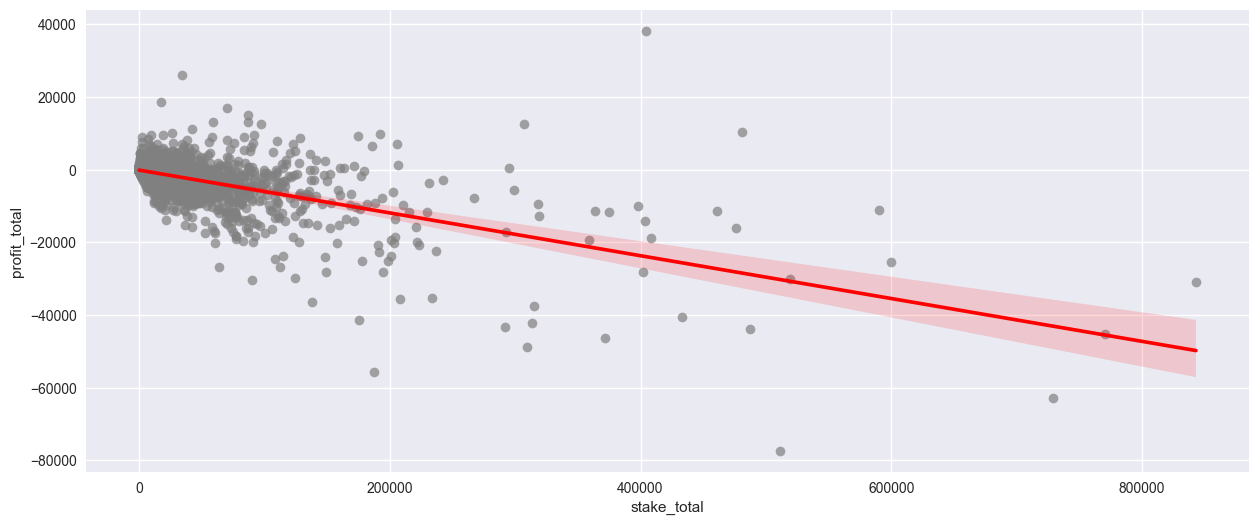

In [86]:
# Visualizing relationships between stake_total and profit_total
plt.figure(figsize=(15, 6))
sns.regplot(data=df, x='stake_total', y='profit_total', scatter_kws={"color": "gray",  "alpha":0.7}, line_kws={"color": "red", "alpha":1})
plt.grid(True)
plt.show()

In [89]:
# features
X = df[['days_total', 'stake_total', 'bets_total']]

# target
y = df['profit_total']

In [90]:
# Polynomial regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

poly_train_errors = []
poly_val_errors = []
poly_degrees = [1, 2, 3, 4]

# split the data into training and test sets.
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# split the training set into training set and validation set. 
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=42)

lin_regr = LinearRegression(fit_intercept=False)

for degree in poly_degrees:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    lin_regr.fit(X_train_poly, y_train)
    
    y_train_pred = lin_regr.predict(X_train_poly)
    train_error = mean_absolute_error(y_train, y_train_pred)
    
    X_val_poly = poly.fit_transform(X_val)
    y_val_pred = lin_regr.predict(X_val_poly)
    val_error = mean_absolute_error(y_val, y_val_pred)
    
    poly_train_errors.append(train_error)
    poly_val_errors.append(val_error)

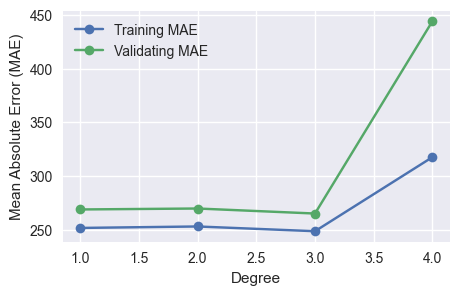

In [91]:
# Plot the learning curve
plt.figure(figsize=(5, 3))
plt.plot(poly_degrees, poly_train_errors, label='Training MAE', marker='o')
plt.plot(poly_degrees, poly_val_errors, label='Validating MAE', marker='o')
plt.xlabel('Degree')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

In [92]:
# Polynomial regression of degree 3 seems has the best performance with the lowest training error
# the lowest validating error. As the degree surpasses 3, the model starts to behave inconsistently 
# and unreliable. 

# Retrain the model using both the training and the validation set (degree = 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
lin_regr.fit(X_train_poly, y_train)
    
y_train_pred = lin_regr.predict(X_train_poly)
train_error = mean_absolute_error(y_train, y_train_pred)

X_test_poly = poly.fit_transform(X_test)
y_test_pred = lin_regr.predict(X_test_poly)
test_error = mean_absolute_error(y_test, y_test_pred)

print('Training error:', train_error)
print('Test error:', test_error)

Training error: 253.65835959125343
Test error: 240.12526026898186


In [93]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# split the data into training and test sets.
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# split the training set into training set and validation set. 
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=42)

range = [50, 100, 150, 200, 250]   
train_errors = []
val_errors = []

for i in range:
    rfr = RandomForestRegressor(n_estimators=i, random_state=42)
    rfr.fit(X_train, y_train)

    y_train_pred = rfr.predict(X_train)
    train_error = mean_absolute_error(y_train, y_train_pred)

    y_val_pred = rfr.predict(X_val)
    val_error = mean_absolute_error(y_val, y_val_pred)  

    train_errors.append(train_error)
    val_errors.append(val_error)    

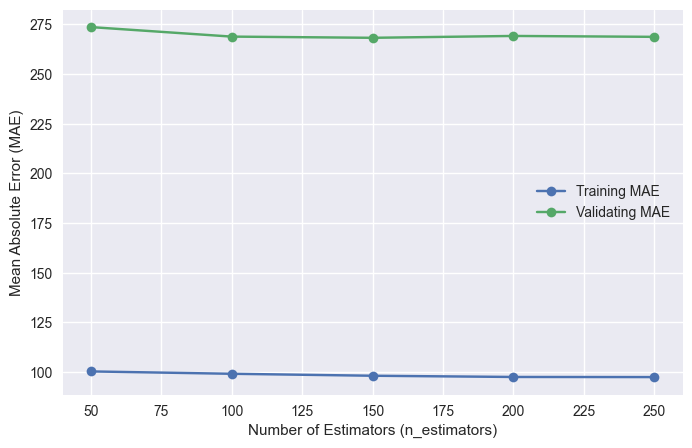

In [97]:
# Plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(range, train_errors, label='Training MAE', marker='o')
plt.plot(range, val_errors, label='Validating MAE', marker='o')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# As the number of estimators increases to 150, training MAE and validating MAE decreases gradually. 
# As the number of estimators surpasses 150, the differences are no longer significant, and 
# the model has been sufficiently optimized.  

In [98]:
# Retrain the model using both the training set and validation set and test the model on the test set
# n_estimators = 150 

# split the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(n_estimators=150, random_state=42)
rfr.fit(X_train, y_train)

y_train_pred = rfr.predict(X_train)
train_error = mean_absolute_error(y_train, y_train_pred)

y_test_pred = rfr.predict(X_test)
test_error = mean_absolute_error(y_test, y_test_pred)

print('Training error:', train_error)
print('Test error:', test_error)

Training error: 98.04974280195806
Test error: 256.26408858772476


In [ ]:
# Comparing the 2 models: random forest regression (n=150) and polynomial regression (degree=3)

# Random forest regression model outperforms polynomial regression model on the training set 
# but polynomial regression model performs slightly better with the test set. 


# The Random Forest Regression model has a lower training error, which suggests it fits the training 
# data well. However, the significantly higher test error indicates a problem with generalization. 